# Text scrapping and Classification

In [1]:
#importing all the required libraries
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen 
import unicodedata
import nltk
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
%matplotlib inline 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Goutham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Collection

In [2]:
#getting all the text data in one place

url_list=[]
url = 'http://mlg.ucd.ie/modules/COMP41680/archive/index.html'
r = requests.get(url)
content = r.text
soup = BeautifulSoup(content, 'lxml')

# find_all('a') filters for only the links present in a web page
#'(x: x !="")' filters unnecesarry links such as cookie info, privacy etc

links = soup.find_all('a',href=lambda x: x !="")
for i in range(0,len(links)):
    link = links[i] 
    #appending the links present using href
    url_list.append(link['href'])
url_list= list(filter(None,url_list))

url_list_level_1=[]
for i in range(0,len(url_list)):
    url = 'http://mlg.ucd.ie/modules/COMP41680/archive/'+url_list[i]
    r = requests.get(url)
    content = r.text
    soup = BeautifulSoup(content, 'lxml')
    links = soup.find_all('a')
    for i in range(0,len(links)):
        link = links[i]
        url_list_level_1.append(link['href'])
        url_list_level_1= list(filter(None, url_list_level_1))

#next we remove the repeated index.html link from acquired list of links obtained above
while 'index.html' in url_list_level_1: url_list_level_1.remove('index.html')

article_list=[]
for i in range(0,len(url_list_level_1)):
    article_list.append('http://mlg.ucd.ie/modules/COMP41680/archive/'+url_list_level_1[i])

    
#getting all the articles 
all_articles =[]
title=[]

for i in range(0,len(article_list)):
    page = urlopen(article_list[i])
    soup = BeautifulSoup(page,'html.parser')
    x=[]
    paragraphs = soup.find_all('p')
    for paragraph in paragraphs:
        x.append(unicodedata.normalize("NFKD",(paragraph.get_text(strip=True))))
    x= ' '.join(x)
    all_articles.append(x)

#getting all the titles 

    y=[]
    title_name = soup.find_all('h2')
    for title_name in title_name:
        y.append(title_name.get_text(strip=True))
    title.append(y)
    title = [''.join(x) for x in title]

#getting all the labels    
labels=[]
for i in range(0,len(url_list)):
    url = 'http://mlg.ucd.ie/modules/COMP41680/archive/'+url_list[i]
    r = requests.get(url)
    content = r.text
    soup = BeautifulSoup(content, 'lxml')
    tags=soup.findAll('td', 'category')
    for t in tags:
        labels.append(unicodedata.normalize("NFKD",(t.get_text())))

labels = [x.strip(' ')for x in labels]
labels_new = list(filter(lambda a: a != 'N/A', labels))

#counting the values to see if all the 3 variables match    
print('count of articles :',len(all_articles))
print('count of titles :',len(title))
print('count of labels :',len(labels_new))

count of articles : 1408
count of titles : 1408
count of labels : 1408


In [3]:
#making the data frame
data_frame = pd.DataFrame(
            {
             'Articles': all_articles,
             'Label_tags': labels_new,   
             'Title': title
             })
data_frame.shape

(1408, 3)

In [4]:
data_frame.head()

Articles  Label_tags  \
0   The sporting industry has come a long way sin...  technology   
1  Asian quake hits European shares  Shares in Eu...    business   
2   BT is offering customers free internet teleph...  technology   
3  Barclays shares up on merger talk  Shares in U...    business   
4   England centre Olly Barkley has been passed f...       sport   

                                               Title  
0  21st-Century Sports: How Digital Technology Is...  
1                   Asian quake hits European shares  
2                     BT offers free net phone calls  
3                  Barclays shares up on merger talk  
4                   Barkley fit for match in Ireland

In [5]:
#saving the dataframe

data_frame.to_csv('final_data.csv', sep=',', encoding='utf-8', index=False)

In [6]:
#get data frame back from the local

reading_data = pd.read_csv('final_data.csv')

In [7]:
#checking for Nulls
reading_data.isnull().sum().any()

False

In [8]:
#looking at the target value distribution
reading_data.Label_tags.value_counts()

sport         526
business      491
technology    391
Name: Label_tags, dtype: int64

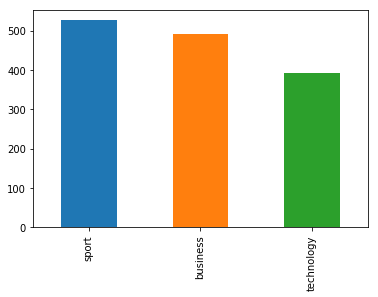

In [9]:
reading_data['Label_tags'].value_counts().plot(kind='bar')

In [10]:
#assinging variables to X and Y
X= reading_data.Articles
Y = reading_data.Label_tags


In [11]:
#splitting data for training and testing 
X_train, X_test, y_train, y_test \
    = train_test_split(X, Y, random_state=0, \
                                    train_size = 0.7, test_size =0.3)

In [12]:
X_train.head(5)

655    Net regulation 'still possible'  The blurring ...
82     Owen may have to return home  Michael Owen has...
921    UK bank seals South Korean deal  UK-based bank...
438    Robinson out of Six Nations  England captain J...
994    India and Russia in energy talks  India and Ru...
Name: Articles, dtype: object

In [13]:
y_train.head()

655    technology
82          sport
921      business
438         sport
994      business
Name: Label_tags, dtype: object

In [15]:
# Done to understand the shape of the matrix
#count_vect = CountVectorizer()
#X_train_counts = count_vect.fit_transform(X_train)
#a = pd.DataFrame(X_train_counts.toarray(), columns=count_vect.get_feature_names())
#X_train_counts.shape
#tfidf_transformer = TfidfTransformer()
#X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
#X_train_tfidf.shape

# Text Classification

In [14]:
#classifier 1
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])
text_clf = text_clf.fit(X_train, y_train)
predicted_new = text_clf.predict(X_test)
NB_classifier=np.mean(predicted_new == y_test)
NB_classifier

0.9763593380614657

In [15]:
# Print performance details
print(metrics.classification_report(y_test, predicted_new))

# Print confusion matrix
print("Confusion Matrix")
print(metrics.confusion_matrix(y_test, predicted_new))

             precision    recall  f1-score   support

   business       0.97      0.98      0.97       138
      sport       0.98      0.98      0.98       170
 technology       0.98      0.97      0.97       115

avg / total       0.98      0.98      0.98       423

Confusion Matrix
[[135   1   2]
 [  3 167   0]
 [  1   3 111]]


In [16]:
#classifier 2
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf_svm', SGDClassifier(loss='hinge', alpha=1e-3, max_iter=5, random_state=42))])
text_clf_svm =text_clf_svm.fit(X_train,y_train)
predicted_svm = text_clf_svm.predict(X_test)
SVM_Classifier=np.mean(predicted_svm == y_test)
SVM_Classifier

0.9858156028368794

In [17]:
# Print performance details
print(metrics.classification_report(y_test, predicted_svm))
print("Confusion Matrix")
print(metrics.confusion_matrix(y_test, predicted_svm))


             precision    recall  f1-score   support

   business       0.97      0.99      0.98       138
      sport       0.99      0.98      0.99       170
 technology       0.99      0.99      0.99       115

avg / total       0.99      0.99      0.99       423

Confusion Matrix
[[137   0   1]
 [  4 166   0]
 [  0   1 114]]


In [18]:
stemmer = SnowballStemmer("english",ignore_stopwords=True)
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')

In [19]:
#classifier 3
text_mnb_stemmed = Pipeline([('vect', stemmed_count_vect),
                             ('tfidf', TfidfTransformer()),
                             ('mnb', MultinomialNB(fit_prior=False))])
text_mnb_stemmed = text_mnb_stemmed.fit(X_train, y_train)
predicted_mnb_stemmed = text_mnb_stemmed.predict(X_test)
NB_stemmed_classifier=np.mean(predicted_mnb_stemmed == y_test)
NB_stemmed_classifier

0.9763593380614657

In [20]:
print(metrics.classification_report(y_test, predicted_mnb_stemmed))
print("Confusion Matrix")
print(metrics.confusion_matrix(y_test, predicted_mnb_stemmed))

             precision    recall  f1-score   support

   business       0.96      0.98      0.97       138
      sport       0.99      0.98      0.98       170
 technology       0.97      0.97      0.97       115

avg / total       0.98      0.98      0.98       423

Confusion Matrix
[[135   0   3]
 [  4 166   0]
 [  1   2 112]]


# Results comparison

In [21]:
objects = ('NB_classifier', 'SVM_Classifier', 'NB_stemmed_classifier')
y_pos = np.arange(len(objects))
performance = [NB_classifier*100,SVM_Classifier*100,NB_stemmed_classifier*100]

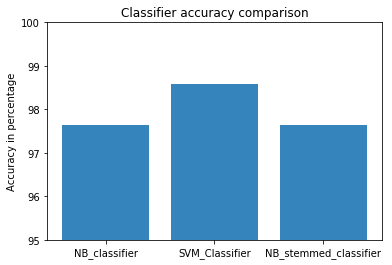

In [29]:
plt.bar(y_pos, performance, align='center', alpha=0.9)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy in percentage')
plt.title('Classifier accuracy comparison')
plt.ylim(ymin=95,ymax=100)
plt.show()

### As we can see, all the 3 classifiers are performing really well with an average of 97.5% and with SVM doing slightly better at 98.5% accuracy.